In [22]:
import os
import sys
import glob
import h5py
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [23]:
#from numpy.random import seed
#seed(1)
#tf.random.set_seed(1)

In [24]:
#for each tau e have = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
#                        'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
array_tau = np.load('ntuples/datGlob_tau.npy')
array_qcd = np.load('ntuples/datGlob_fake_tau.npy')
print(array_tau.shape)
print(array_qcd.shape)

(4916408, 9)
(1060682, 9)


### Preprocessing

In [25]:
big_array = np.append(array_tau,array_qcd, axis=0)
big_array.shape
scaler = MinMaxScaler()
scaler.fit(big_array)
big_array_scaled = scaler.transform(big_array)

In [26]:
array_tau_scaled = scaler.transform(array_tau)
array_qcd_scaled = scaler.transform(array_qcd)
print(array_tau_scaled[len(array_tau_scaled)-1,:])
print(big_array_scaled[len(array_tau_scaled)-1,:])

comparison = array_tau_scaled == big_array_scaled[:len(array_tau_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays)

[6.16777963e-04 4.71145740e-01 3.18440545e-07 2.44677528e-01
 2.58403443e-01 7.41596568e-01 5.22282393e-02 1.58288801e-01
 4.31566026e-02]
[6.16777963e-04 4.71145740e-01 3.18440545e-07 2.44677528e-01
 2.58403443e-01 7.41596568e-01 5.22282393e-02 1.58288801e-01
 4.31566026e-02]
True


In [27]:
train = {}
test = {}

test_percentage = 18#%
test_len = math.floor(len(array_tau)*test_percentage/100)

test_len = 50000
test['features'] = array_tau_scaled[:test_len]
test['features'] = np.append(test['features'], array_qcd_scaled[:test_len], axis = 0)
test['label'] = np.ones(test_len)
test['label'] = np.append(test['label'],np.zeros(test_len), axis = 0)

train_len = 200000
train['features'] = array_tau_scaled[test_len:train_len+test_len]
train['features'] = np.append(train['features'], array_qcd_scaled[test_len:train_len+test_len], axis = 0)
train['label'] = np.ones( train_len )
train['label'] = np.append(train['label'], np.zeros(train_len), axis = 0)
print(train['label'][49999])

1.0


In [28]:
print(train['features'].shape)
print(test['features'].shape)
print(train['label'].shape)
print(test['label'].shape)

(400000, 9)
(100000, 9)
(400000,)
(100000,)


In [29]:
def shuffle(dict_data, seed=None):
    if seed is not None:
        np.random.seed(seed)
    shuffle_indices = np.arange( len(dict_data['label']))#Len data.points has to be the same for data.features and data.label
    np.random.shuffle(shuffle_indices)
    for k in dict_data:
        dict_data[k] = dict_data[k][shuffle_indices]
    return shuffle_indices, dict_data

In [30]:
%matplotlib notebook

<IPython.core.display.Javascript object>


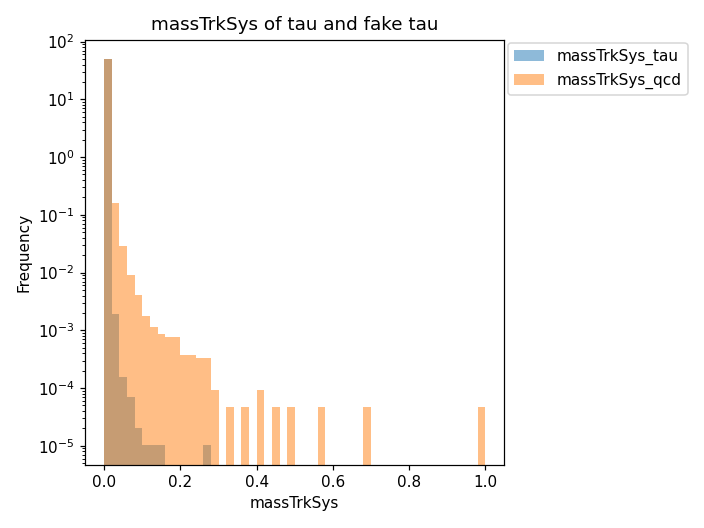

In [31]:
set_variable = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
                'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
xlow = [0, -2000, 0, -1400, -1, -15, 0, 0, 0]
xup = [80, 1000, 0.4*10**6, 1400, 15, 2.5, 0.4, 10000, 2.5*10**6]
setted_var = 2 #btw 0 and 8
n_bins=50
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(array_tau_scaled[:,setted_var], bins=n_bins , label=set_variable[setted_var]+'_tau', lw=0.5, alpha=0.5, density=True, range=[0,1])#[xlow[setted_var], xup[setted_var]])
ax1.hist(array_qcd_scaled[:,setted_var], bins=n_bins , label=set_variable[setted_var]+'_qcd', lw=0.5, alpha=0.5, density=True, range=[0,1])#[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and fake tau")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

In [32]:
print(array_tau[:len(array_qcd),setted_var].shape)
print(array_qcd[:,setted_var].shape)

(1060682,)
(1060682,)


In [33]:
#printing correlation between variables
intra_tau = array_tau_scaled.mean(axis=1)
intra_qcd = array_qcd_scaled.mean(axis=1)

<IPython.core.display.Javascript object>


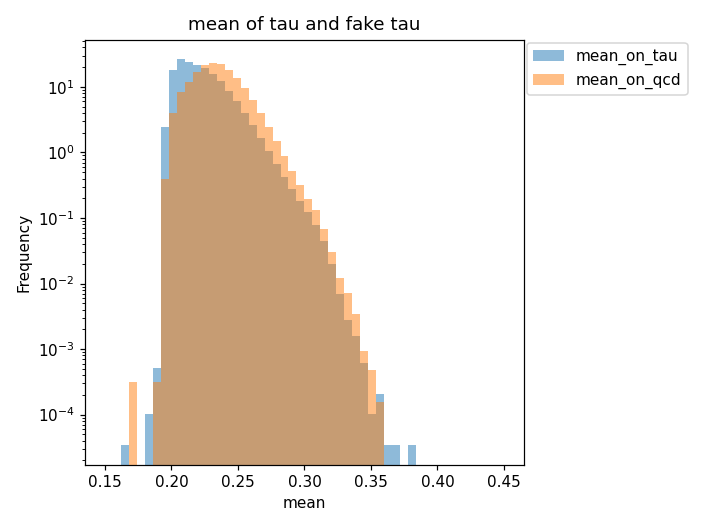

In [34]:
n_bins=50
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(intra_tau, bins=n_bins , label='mean_on_tau', lw=0.5, alpha=0.5, density=True, range=[0.15,0.45])
ax1.hist(intra_qcd, bins=n_bins , label='mean_on_qcd', lw=0.5, alpha=0.5, density=True, range=[0.15,0.45])
plt.title("mean of tau and fake tau")
plt.xlabel('mean')
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

### Start testing DL models

In [43]:
model_1 = tf.keras.models.Sequential(name="model_MLP", layers=[
    tf.keras.Input(shape=(9), dtype='float32'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64,activation="relu", dtype='float32'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation="relu", dtype='float32'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32,activation="relu", dtype='float32'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model_1.summary()

Model: "model_MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                640       
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0 

In [48]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 90:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr
opt =tf.keras.optimizers.Adam(learning_rate=lr_schedule(0))

model_1.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'MLP_on_GlobTau_Dropout.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [checkpoint, lr_scheduler]

[2022-03-18 11:29:32,352] INFO: Learning rate: 0.001000


In [49]:
train_scaled = train['features']
test_scaled = test['features']

In [50]:
np.min(train_scaled,axis=0)

array([3.05346476e-07, 0.00000000e+00, 3.18416393e-07, 2.44677528e-01,
       1.72109872e-01, 2.35540685e-01, 8.68822442e-05, 0.00000000e+00,
       0.00000000e+00])

We now select only track-related variables, which are :ipSigLeadTrk(1), massTrkSys(2), trFlightPathSig(3), DeltaR(6).

In [51]:
#g = [False,True, True,True,False,False,True,False,False]
shuffled_ind, train = shuffle(train)
shuffled_ind, test = shuffle(test)
history = model_1.fit(
    train['features'][:],
    train['label'],
    batch_size=512,
    epochs=300,
    shuffle=True,
    validation_data = (test['features'][:],test['label']),
    callbacks = callbacks)

[2022-03-18 11:29:34,143] INFO: Learning rate: 0.001000


Epoch 1/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5832 - accuracy: 0.7096 - val_loss: 0.5939 - val_accuracy: 0.7250


[2022-03-18 11:29:38,558] INFO: Learning rate: 0.001000



Epoch 00001: val_accuracy improved from -inf to 0.72503, saving model to model_checkpoints/MLP_on_GlobTau_Dropout.h5
Epoch 2/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5788 - accuracy: 0.7107 - val_loss: 0.5915 - val_accuracy: 0.7207


[2022-03-18 11:29:42,324] INFO: Learning rate: 0.001000



Epoch 00002: val_accuracy did not improve from 0.72503
Epoch 3/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5757 - accuracy: 0.7129 - val_loss: 0.5976 - val_accuracy: 0.7283


[2022-03-18 11:29:46,065] INFO: Learning rate: 0.001000



Epoch 00003: val_accuracy improved from 0.72503 to 0.72833, saving model to model_checkpoints/MLP_on_GlobTau_Dropout.h5
Epoch 4/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5741 - accuracy: 0.7142 - val_loss: 0.6028 - val_accuracy: 0.7288


[2022-03-18 11:29:49,745] INFO: Learning rate: 0.001000



Epoch 00004: val_accuracy improved from 0.72833 to 0.72877, saving model to model_checkpoints/MLP_on_GlobTau_Dropout.h5
Epoch 5/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5732 - accuracy: 0.7147 - val_loss: 0.5921 - val_accuracy: 0.7337


[2022-03-18 11:29:53,558] INFO: Learning rate: 0.001000



Epoch 00005: val_accuracy improved from 0.72877 to 0.73370, saving model to model_checkpoints/MLP_on_GlobTau_Dropout.h5
Epoch 6/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5718 - accuracy: 0.7146 - val_loss: 0.5978 - val_accuracy: 0.7279


[2022-03-18 11:29:57,348] INFO: Learning rate: 0.001000



Epoch 00006: val_accuracy did not improve from 0.73370
Epoch 7/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5716 - accuracy: 0.7145 - val_loss: 0.6089 - val_accuracy: 0.7261


[2022-03-18 11:30:01,109] INFO: Learning rate: 0.001000



Epoch 00007: val_accuracy did not improve from 0.73370
Epoch 8/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5711 - accuracy: 0.7152 - val_loss: 0.6079 - val_accuracy: 0.7274


[2022-03-18 11:30:04,827] INFO: Learning rate: 0.001000



Epoch 00008: val_accuracy did not improve from 0.73370
Epoch 9/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5708 - accuracy: 0.7151 - val_loss: 0.5993 - val_accuracy: 0.7136


[2022-03-18 11:30:08,558] INFO: Learning rate: 0.001000



Epoch 00009: val_accuracy did not improve from 0.73370
Epoch 10/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5701 - accuracy: 0.7160 - val_loss: 0.6218 - val_accuracy: 0.7212


[2022-03-18 11:30:12,284] INFO: Learning rate: 0.001000



Epoch 00010: val_accuracy did not improve from 0.73370
Epoch 11/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5690 - accuracy: 0.7165 - val_loss: 0.6103 - val_accuracy: 0.7185


[2022-03-18 11:30:16,039] INFO: Learning rate: 0.001000



Epoch 00011: val_accuracy did not improve from 0.73370
Epoch 12/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5683 - accuracy: 0.7168 - val_loss: 0.6102 - val_accuracy: 0.7153


[2022-03-18 11:30:19,828] INFO: Learning rate: 0.001000



Epoch 00012: val_accuracy did not improve from 0.73370
Epoch 13/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5681 - accuracy: 0.7175 - val_loss: 0.6250 - val_accuracy: 0.7217


[2022-03-18 11:30:23,572] INFO: Learning rate: 0.001000



Epoch 00013: val_accuracy did not improve from 0.73370
Epoch 14/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5680 - accuracy: 0.7168 - val_loss: 0.6178 - val_accuracy: 0.7206


[2022-03-18 11:30:27,292] INFO: Learning rate: 0.001000



Epoch 00014: val_accuracy did not improve from 0.73370
Epoch 15/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5671 - accuracy: 0.7172 - val_loss: 0.6311 - val_accuracy: 0.7153


[2022-03-18 11:30:31,059] INFO: Learning rate: 0.001000



Epoch 00015: val_accuracy did not improve from 0.73370
Epoch 16/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5671 - accuracy: 0.7174 - val_loss: 0.6152 - val_accuracy: 0.7252


[2022-03-18 11:30:34,817] INFO: Learning rate: 0.001000



Epoch 00016: val_accuracy did not improve from 0.73370
Epoch 17/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5671 - accuracy: 0.7178 - val_loss: 0.6197 - val_accuracy: 0.7224


[2022-03-18 11:30:38,596] INFO: Learning rate: 0.001000



Epoch 00017: val_accuracy did not improve from 0.73370
Epoch 18/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5659 - accuracy: 0.7180 - val_loss: 0.6303 - val_accuracy: 0.7218


[2022-03-18 11:30:42,328] INFO: Learning rate: 0.001000



Epoch 00018: val_accuracy did not improve from 0.73370
Epoch 19/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5656 - accuracy: 0.7184 - val_loss: 0.6358 - val_accuracy: 0.7238


[2022-03-18 11:30:46,010] INFO: Learning rate: 0.001000



Epoch 00019: val_accuracy did not improve from 0.73370
Epoch 20/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5666 - accuracy: 0.7176 - val_loss: 0.6209 - val_accuracy: 0.7234


[2022-03-18 11:30:49,717] INFO: Learning rate: 0.001000



Epoch 00020: val_accuracy did not improve from 0.73370
Epoch 21/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5656 - accuracy: 0.7187 - val_loss: 0.6265 - val_accuracy: 0.7240


[2022-03-18 11:30:53,398] INFO: Learning rate: 0.001000



Epoch 00021: val_accuracy did not improve from 0.73370
Epoch 22/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5651 - accuracy: 0.7182 - val_loss: 0.6271 - val_accuracy: 0.7172


[2022-03-18 11:30:57,127] INFO: Learning rate: 0.001000



Epoch 00022: val_accuracy did not improve from 0.73370
Epoch 23/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5648 - accuracy: 0.7187 - val_loss: 0.6272 - val_accuracy: 0.7231


[2022-03-18 11:31:00,871] INFO: Learning rate: 0.001000



Epoch 00023: val_accuracy did not improve from 0.73370
Epoch 24/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5651 - accuracy: 0.7184 - val_loss: 0.6181 - val_accuracy: 0.7228


[2022-03-18 11:31:04,641] INFO: Learning rate: 0.001000



Epoch 00024: val_accuracy did not improve from 0.73370
Epoch 25/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5649 - accuracy: 0.7188 - val_loss: 0.6244 - val_accuracy: 0.7187


[2022-03-18 11:31:08,367] INFO: Learning rate: 0.001000



Epoch 00025: val_accuracy did not improve from 0.73370
Epoch 26/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5647 - accuracy: 0.7189 - val_loss: 0.6273 - val_accuracy: 0.7132


[2022-03-18 11:31:12,102] INFO: Learning rate: 0.001000



Epoch 00026: val_accuracy did not improve from 0.73370
Epoch 27/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5653 - accuracy: 0.7185 - val_loss: 0.6211 - val_accuracy: 0.7272


[2022-03-18 11:31:15,875] INFO: Learning rate: 0.001000



Epoch 00027: val_accuracy did not improve from 0.73370
Epoch 28/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5647 - accuracy: 0.7193 - val_loss: 0.6250 - val_accuracy: 0.7220


[2022-03-18 11:31:19,670] INFO: Learning rate: 0.001000



Epoch 00028: val_accuracy did not improve from 0.73370
Epoch 29/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5640 - accuracy: 0.7200 - val_loss: 0.6180 - val_accuracy: 0.7243


[2022-03-18 11:31:23,440] INFO: Learning rate: 0.001000



Epoch 00029: val_accuracy did not improve from 0.73370
Epoch 30/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5636 - accuracy: 0.7194 - val_loss: 0.6208 - val_accuracy: 0.7245


[2022-03-18 11:31:27,228] INFO: Learning rate: 0.001000



Epoch 00030: val_accuracy did not improve from 0.73370
Epoch 31/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5632 - accuracy: 0.7195 - val_loss: 0.6129 - val_accuracy: 0.7233


[2022-03-18 11:31:30,917] INFO: Learning rate: 0.001000



Epoch 00031: val_accuracy did not improve from 0.73370
Epoch 32/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5646 - accuracy: 0.7193 - val_loss: 0.6186 - val_accuracy: 0.7228


[2022-03-18 11:31:34,754] INFO: Learning rate: 0.001000



Epoch 00032: val_accuracy did not improve from 0.73370
Epoch 33/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5644 - accuracy: 0.7190 - val_loss: 0.6283 - val_accuracy: 0.7190


[2022-03-18 11:31:38,673] INFO: Learning rate: 0.001000



Epoch 00033: val_accuracy did not improve from 0.73370
Epoch 34/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5635 - accuracy: 0.7204 - val_loss: 0.6211 - val_accuracy: 0.7135


[2022-03-18 11:31:42,593] INFO: Learning rate: 0.001000



Epoch 00034: val_accuracy did not improve from 0.73370
Epoch 35/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5630 - accuracy: 0.7197 - val_loss: 0.6162 - val_accuracy: 0.7290


[2022-03-18 11:31:46,294] INFO: Learning rate: 0.001000



Epoch 00035: val_accuracy did not improve from 0.73370
Epoch 36/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5628 - accuracy: 0.7202 - val_loss: 0.6049 - val_accuracy: 0.7218


[2022-03-18 11:31:50,003] INFO: Learning rate: 0.001000



Epoch 00036: val_accuracy did not improve from 0.73370
Epoch 37/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5635 - accuracy: 0.7201 - val_loss: 0.6090 - val_accuracy: 0.7178


[2022-03-18 11:31:53,787] INFO: Learning rate: 0.001000



Epoch 00037: val_accuracy did not improve from 0.73370
Epoch 38/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5637 - accuracy: 0.7191 - val_loss: 0.6136 - val_accuracy: 0.7247


[2022-03-18 11:31:57,619] INFO: Learning rate: 0.001000



Epoch 00038: val_accuracy did not improve from 0.73370
Epoch 39/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5636 - accuracy: 0.7198 - val_loss: 0.6273 - val_accuracy: 0.7241


[2022-03-18 11:32:01,389] INFO: Learning rate: 0.001000



Epoch 00039: val_accuracy did not improve from 0.73370
Epoch 40/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5629 - accuracy: 0.7199 - val_loss: 0.6236 - val_accuracy: 0.7220


[2022-03-18 11:32:05,085] INFO: Learning rate: 0.001000



Epoch 00040: val_accuracy did not improve from 0.73370
Epoch 41/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5637 - accuracy: 0.7197 - val_loss: 0.6196 - val_accuracy: 0.7206


[2022-03-18 11:32:08,771] INFO: Learning rate: 0.001000



Epoch 00041: val_accuracy did not improve from 0.73370
Epoch 42/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5624 - accuracy: 0.7205 - val_loss: 0.6150 - val_accuracy: 0.7300


[2022-03-18 11:32:12,494] INFO: Learning rate: 0.001000



Epoch 00042: val_accuracy did not improve from 0.73370
Epoch 43/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5624 - accuracy: 0.7198 - val_loss: 0.6181 - val_accuracy: 0.7262


[2022-03-18 11:32:16,274] INFO: Learning rate: 0.001000



Epoch 00043: val_accuracy did not improve from 0.73370
Epoch 44/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5633 - accuracy: 0.7203 - val_loss: 0.6151 - val_accuracy: 0.7316


[2022-03-18 11:32:20,035] INFO: Learning rate: 0.001000



Epoch 00044: val_accuracy did not improve from 0.73370
Epoch 45/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5625 - accuracy: 0.7203 - val_loss: 0.6033 - val_accuracy: 0.7279


[2022-03-18 11:32:23,772] INFO: Learning rate: 0.001000



Epoch 00045: val_accuracy did not improve from 0.73370
Epoch 46/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5631 - accuracy: 0.7198 - val_loss: 0.6172 - val_accuracy: 0.7266


[2022-03-18 11:32:27,530] INFO: Learning rate: 0.001000



Epoch 00046: val_accuracy did not improve from 0.73370
Epoch 47/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5631 - accuracy: 0.7199 - val_loss: 0.5928 - val_accuracy: 0.7228


[2022-03-18 11:32:31,265] INFO: Learning rate: 0.001000



Epoch 00047: val_accuracy did not improve from 0.73370
Epoch 48/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5622 - accuracy: 0.7205 - val_loss: 0.5957 - val_accuracy: 0.7163


[2022-03-18 11:32:35,049] INFO: Learning rate: 0.001000



Epoch 00048: val_accuracy did not improve from 0.73370
Epoch 49/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5627 - accuracy: 0.7201 - val_loss: 0.6148 - val_accuracy: 0.7227


[2022-03-18 11:32:38,774] INFO: Learning rate: 0.001000



Epoch 00049: val_accuracy did not improve from 0.73370
Epoch 50/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5619 - accuracy: 0.7208 - val_loss: 0.6012 - val_accuracy: 0.7275


[2022-03-18 11:32:42,510] INFO: Learning rate: 0.001000



Epoch 00050: val_accuracy did not improve from 0.73370
Epoch 51/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5622 - accuracy: 0.7211 - val_loss: 0.6032 - val_accuracy: 0.7248


[2022-03-18 11:32:46,263] INFO: Learning rate: 0.001000



Epoch 00051: val_accuracy did not improve from 0.73370
Epoch 52/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5627 - accuracy: 0.7204 - val_loss: 0.6039 - val_accuracy: 0.7330


[2022-03-18 11:32:50,050] INFO: Learning rate: 0.001000



Epoch 00052: val_accuracy did not improve from 0.73370
Epoch 53/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5627 - accuracy: 0.7211 - val_loss: 0.6122 - val_accuracy: 0.7198


[2022-03-18 11:32:53,788] INFO: Learning rate: 0.001000



Epoch 00053: val_accuracy did not improve from 0.73370
Epoch 54/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5627 - accuracy: 0.7205 - val_loss: 0.6083 - val_accuracy: 0.7242


[2022-03-18 11:32:57,531] INFO: Learning rate: 0.001000



Epoch 00054: val_accuracy did not improve from 0.73370
Epoch 55/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5624 - accuracy: 0.7202 - val_loss: 0.6032 - val_accuracy: 0.7227


[2022-03-18 11:33:01,317] INFO: Learning rate: 0.001000



Epoch 00055: val_accuracy did not improve from 0.73370
Epoch 56/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5619 - accuracy: 0.7207 - val_loss: 0.6166 - val_accuracy: 0.7239


[2022-03-18 11:33:05,039] INFO: Learning rate: 0.001000



Epoch 00056: val_accuracy did not improve from 0.73370
Epoch 57/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5620 - accuracy: 0.7206 - val_loss: 0.6149 - val_accuracy: 0.7196


[2022-03-18 11:33:08,792] INFO: Learning rate: 0.001000



Epoch 00057: val_accuracy did not improve from 0.73370
Epoch 58/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5614 - accuracy: 0.7207 - val_loss: 0.6072 - val_accuracy: 0.7154


[2022-03-18 11:33:12,565] INFO: Learning rate: 0.001000



Epoch 00058: val_accuracy did not improve from 0.73370
Epoch 59/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5618 - accuracy: 0.7205 - val_loss: 0.6190 - val_accuracy: 0.7127


[2022-03-18 11:33:16,268] INFO: Learning rate: 0.001000



Epoch 00059: val_accuracy did not improve from 0.73370
Epoch 60/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5621 - accuracy: 0.7207 - val_loss: 0.6046 - val_accuracy: 0.7142


[2022-03-18 11:33:20,010] INFO: Learning rate: 0.001000



Epoch 00060: val_accuracy did not improve from 0.73370
Epoch 61/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5620 - accuracy: 0.7208 - val_loss: 0.6229 - val_accuracy: 0.7219


[2022-03-18 11:33:23,767] INFO: Learning rate: 0.001000



Epoch 00061: val_accuracy did not improve from 0.73370
Epoch 62/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5617 - accuracy: 0.7206 - val_loss: 0.6050 - val_accuracy: 0.7206


[2022-03-18 11:33:27,488] INFO: Learning rate: 0.001000



Epoch 00062: val_accuracy did not improve from 0.73370
Epoch 63/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5619 - accuracy: 0.7209 - val_loss: 0.5865 - val_accuracy: 0.7299


[2022-03-18 11:33:31,210] INFO: Learning rate: 0.001000



Epoch 00063: val_accuracy did not improve from 0.73370
Epoch 64/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5613 - accuracy: 0.7218 - val_loss: 0.6135 - val_accuracy: 0.7167


[2022-03-18 11:33:34,903] INFO: Learning rate: 0.001000



Epoch 00064: val_accuracy did not improve from 0.73370
Epoch 65/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5612 - accuracy: 0.7209 - val_loss: 0.6134 - val_accuracy: 0.7186


[2022-03-18 11:33:38,642] INFO: Learning rate: 0.001000



Epoch 00065: val_accuracy did not improve from 0.73370
Epoch 66/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5613 - accuracy: 0.7214 - val_loss: 0.6123 - val_accuracy: 0.7184


[2022-03-18 11:33:42,370] INFO: Learning rate: 0.001000



Epoch 00066: val_accuracy did not improve from 0.73370
Epoch 67/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5609 - accuracy: 0.7218 - val_loss: 0.5916 - val_accuracy: 0.7108


[2022-03-18 11:33:46,040] INFO: Learning rate: 0.001000



Epoch 00067: val_accuracy did not improve from 0.73370
Epoch 68/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5604 - accuracy: 0.7214 - val_loss: 0.6091 - val_accuracy: 0.7095


[2022-03-18 11:33:49,807] INFO: Learning rate: 0.001000



Epoch 00068: val_accuracy did not improve from 0.73370
Epoch 69/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5613 - accuracy: 0.7210 - val_loss: 0.6043 - val_accuracy: 0.7167


[2022-03-18 11:33:53,553] INFO: Learning rate: 0.001000



Epoch 00069: val_accuracy did not improve from 0.73370
Epoch 70/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5609 - accuracy: 0.7218 - val_loss: 0.5957 - val_accuracy: 0.7170


[2022-03-18 11:33:57,279] INFO: Learning rate: 0.001000



Epoch 00070: val_accuracy did not improve from 0.73370
Epoch 71/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5608 - accuracy: 0.7213 - val_loss: 0.5961 - val_accuracy: 0.7280


[2022-03-18 11:34:01,023] INFO: Learning rate: 0.001000



Epoch 00071: val_accuracy did not improve from 0.73370
Epoch 72/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5611 - accuracy: 0.7215 - val_loss: 0.5872 - val_accuracy: 0.7158


[2022-03-18 11:34:04,795] INFO: Learning rate: 0.001000



Epoch 00072: val_accuracy did not improve from 0.73370
Epoch 73/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5614 - accuracy: 0.7211 - val_loss: 0.5969 - val_accuracy: 0.7123


[2022-03-18 11:34:08,481] INFO: Learning rate: 0.001000



Epoch 00073: val_accuracy did not improve from 0.73370
Epoch 74/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5609 - accuracy: 0.7217 - val_loss: 0.6044 - val_accuracy: 0.7162


[2022-03-18 11:34:12,177] INFO: Learning rate: 0.001000



Epoch 00074: val_accuracy did not improve from 0.73370
Epoch 75/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5610 - accuracy: 0.7214 - val_loss: 0.6035 - val_accuracy: 0.7156


[2022-03-18 11:34:15,930] INFO: Learning rate: 0.001000



Epoch 00075: val_accuracy did not improve from 0.73370
Epoch 76/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5608 - accuracy: 0.7218 - val_loss: 0.5985 - val_accuracy: 0.7184


[2022-03-18 11:34:19,686] INFO: Learning rate: 0.001000



Epoch 00076: val_accuracy did not improve from 0.73370
Epoch 77/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5602 - accuracy: 0.7214 - val_loss: 0.5946 - val_accuracy: 0.7253


[2022-03-18 11:34:23,427] INFO: Learning rate: 0.001000



Epoch 00077: val_accuracy did not improve from 0.73370
Epoch 78/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5601 - accuracy: 0.7219 - val_loss: 0.6054 - val_accuracy: 0.7202


[2022-03-18 11:34:27,148] INFO: Learning rate: 0.001000



Epoch 00078: val_accuracy did not improve from 0.73370
Epoch 79/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5609 - accuracy: 0.7212 - val_loss: 0.5944 - val_accuracy: 0.7262


[2022-03-18 11:34:30,905] INFO: Learning rate: 0.001000



Epoch 00079: val_accuracy did not improve from 0.73370
Epoch 80/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5605 - accuracy: 0.7221 - val_loss: 0.5860 - val_accuracy: 0.7153


[2022-03-18 11:34:34,643] INFO: Learning rate: 0.001000



Epoch 00080: val_accuracy did not improve from 0.73370
Epoch 81/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5607 - accuracy: 0.7221 - val_loss: 0.6018 - val_accuracy: 0.7227


[2022-03-18 11:34:38,355] INFO: Learning rate: 0.001000



Epoch 00081: val_accuracy did not improve from 0.73370
Epoch 82/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5609 - accuracy: 0.7214 - val_loss: 0.5947 - val_accuracy: 0.7130


[2022-03-18 11:34:42,051] INFO: Learning rate: 0.001000



Epoch 00082: val_accuracy did not improve from 0.73370
Epoch 83/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5596 - accuracy: 0.7219 - val_loss: 0.5944 - val_accuracy: 0.7164


[2022-03-18 11:34:45,766] INFO: Learning rate: 0.001000



Epoch 00083: val_accuracy did not improve from 0.73370
Epoch 84/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5607 - accuracy: 0.7211 - val_loss: 0.5922 - val_accuracy: 0.7203


[2022-03-18 11:34:49,440] INFO: Learning rate: 0.001000



Epoch 00084: val_accuracy did not improve from 0.73370
Epoch 85/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5604 - accuracy: 0.7213 - val_loss: 0.6049 - val_accuracy: 0.7161


[2022-03-18 11:34:53,202] INFO: Learning rate: 0.001000



Epoch 00085: val_accuracy did not improve from 0.73370
Epoch 86/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5606 - accuracy: 0.7219 - val_loss: 0.6035 - val_accuracy: 0.7171


[2022-03-18 11:34:56,984] INFO: Learning rate: 0.001000



Epoch 00086: val_accuracy did not improve from 0.73370
Epoch 87/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5599 - accuracy: 0.7221 - val_loss: 0.5995 - val_accuracy: 0.7231


[2022-03-18 11:35:00,727] INFO: Learning rate: 0.001000



Epoch 00087: val_accuracy did not improve from 0.73370
Epoch 88/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5606 - accuracy: 0.7210 - val_loss: 0.6062 - val_accuracy: 0.7199


[2022-03-18 11:35:04,490] INFO: Learning rate: 0.001000



Epoch 00088: val_accuracy did not improve from 0.73370
Epoch 89/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5606 - accuracy: 0.7219 - val_loss: 0.5962 - val_accuracy: 0.7176


[2022-03-18 11:35:08,295] INFO: Learning rate: 0.001000



Epoch 00089: val_accuracy did not improve from 0.73370
Epoch 90/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5599 - accuracy: 0.7223 - val_loss: 0.5751 - val_accuracy: 0.7239


[2022-03-18 11:35:12,119] INFO: Learning rate: 0.001000



Epoch 00090: val_accuracy did not improve from 0.73370
Epoch 91/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5607 - accuracy: 0.7218 - val_loss: 0.5941 - val_accuracy: 0.7223


[2022-03-18 11:35:15,873] INFO: Learning rate: 0.000100



Epoch 00091: val_accuracy did not improve from 0.73370
Epoch 92/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5586 - accuracy: 0.7229 - val_loss: 0.6007 - val_accuracy: 0.7146


[2022-03-18 11:35:19,628] INFO: Learning rate: 0.000100



Epoch 00092: val_accuracy did not improve from 0.73370
Epoch 93/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5586 - accuracy: 0.7236 - val_loss: 0.5994 - val_accuracy: 0.7183


[2022-03-18 11:35:23,424] INFO: Learning rate: 0.000100



Epoch 00093: val_accuracy did not improve from 0.73370
Epoch 94/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5584 - accuracy: 0.7232 - val_loss: 0.5962 - val_accuracy: 0.7174


[2022-03-18 11:35:27,129] INFO: Learning rate: 0.000100



Epoch 00094: val_accuracy did not improve from 0.73370
Epoch 95/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5584 - accuracy: 0.7234 - val_loss: 0.5978 - val_accuracy: 0.7189


[2022-03-18 11:35:30,861] INFO: Learning rate: 0.000100



Epoch 00095: val_accuracy did not improve from 0.73370
Epoch 96/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5579 - accuracy: 0.7239 - val_loss: 0.5951 - val_accuracy: 0.7168


[2022-03-18 11:35:34,574] INFO: Learning rate: 0.000100



Epoch 00096: val_accuracy did not improve from 0.73370
Epoch 97/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5579 - accuracy: 0.7232 - val_loss: 0.5953 - val_accuracy: 0.7153


[2022-03-18 11:35:38,353] INFO: Learning rate: 0.000100



Epoch 00097: val_accuracy did not improve from 0.73370
Epoch 98/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5581 - accuracy: 0.7239 - val_loss: 0.5959 - val_accuracy: 0.7196


[2022-03-18 11:35:42,138] INFO: Learning rate: 0.000100



Epoch 00098: val_accuracy did not improve from 0.73370
Epoch 99/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5578 - accuracy: 0.7244 - val_loss: 0.5936 - val_accuracy: 0.7187


[2022-03-18 11:35:45,913] INFO: Learning rate: 0.000100



Epoch 00099: val_accuracy did not improve from 0.73370
Epoch 100/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5581 - accuracy: 0.7234 - val_loss: 0.5932 - val_accuracy: 0.7168


[2022-03-18 11:35:49,674] INFO: Learning rate: 0.000100



Epoch 00100: val_accuracy did not improve from 0.73370
Epoch 101/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5583 - accuracy: 0.7232 - val_loss: 0.5933 - val_accuracy: 0.7151


[2022-03-18 11:35:53,417] INFO: Learning rate: 0.000100



Epoch 00101: val_accuracy did not improve from 0.73370
Epoch 102/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5581 - accuracy: 0.7230 - val_loss: 0.5964 - val_accuracy: 0.7160


[2022-03-18 11:35:57,191] INFO: Learning rate: 0.000100



Epoch 00102: val_accuracy did not improve from 0.73370
Epoch 103/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7237 - val_loss: 0.5980 - val_accuracy: 0.7202


[2022-03-18 11:36:00,980] INFO: Learning rate: 0.000100



Epoch 00103: val_accuracy did not improve from 0.73370
Epoch 104/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5575 - accuracy: 0.7230 - val_loss: 0.5969 - val_accuracy: 0.7183


[2022-03-18 11:36:04,732] INFO: Learning rate: 0.000100



Epoch 00104: val_accuracy did not improve from 0.73370
Epoch 105/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5580 - accuracy: 0.7230 - val_loss: 0.5941 - val_accuracy: 0.7191


[2022-03-18 11:36:08,441] INFO: Learning rate: 0.000100



Epoch 00105: val_accuracy did not improve from 0.73370
Epoch 106/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5577 - accuracy: 0.7239 - val_loss: 0.5951 - val_accuracy: 0.7234


[2022-03-18 11:36:12,139] INFO: Learning rate: 0.000100



Epoch 00106: val_accuracy did not improve from 0.73370
Epoch 107/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5581 - accuracy: 0.7241 - val_loss: 0.5932 - val_accuracy: 0.7231


[2022-03-18 11:36:15,921] INFO: Learning rate: 0.000100



Epoch 00107: val_accuracy did not improve from 0.73370
Epoch 108/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5577 - accuracy: 0.7237 - val_loss: 0.5964 - val_accuracy: 0.7204


[2022-03-18 11:36:19,676] INFO: Learning rate: 0.000100



Epoch 00108: val_accuracy did not improve from 0.73370
Epoch 109/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7237 - val_loss: 0.5916 - val_accuracy: 0.7159


[2022-03-18 11:36:23,453] INFO: Learning rate: 0.000100



Epoch 00109: val_accuracy did not improve from 0.73370
Epoch 110/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5578 - accuracy: 0.7236 - val_loss: 0.5909 - val_accuracy: 0.7196


[2022-03-18 11:36:27,180] INFO: Learning rate: 0.000100



Epoch 00110: val_accuracy did not improve from 0.73370
Epoch 111/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5576 - accuracy: 0.7231 - val_loss: 0.5936 - val_accuracy: 0.7189


[2022-03-18 11:36:30,914] INFO: Learning rate: 0.000100



Epoch 00111: val_accuracy did not improve from 0.73370
Epoch 112/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7242 - val_loss: 0.5926 - val_accuracy: 0.7176


[2022-03-18 11:36:34,677] INFO: Learning rate: 0.000100



Epoch 00112: val_accuracy did not improve from 0.73370
Epoch 113/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5582 - accuracy: 0.7234 - val_loss: 0.5983 - val_accuracy: 0.7181


[2022-03-18 11:36:38,429] INFO: Learning rate: 0.000100



Epoch 00113: val_accuracy did not improve from 0.73370
Epoch 114/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5580 - accuracy: 0.7236 - val_loss: 0.5932 - val_accuracy: 0.7170


[2022-03-18 11:36:42,165] INFO: Learning rate: 0.000100



Epoch 00114: val_accuracy did not improve from 0.73370
Epoch 115/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5579 - accuracy: 0.7240 - val_loss: 0.5901 - val_accuracy: 0.7181


[2022-03-18 11:36:45,893] INFO: Learning rate: 0.000100



Epoch 00115: val_accuracy did not improve from 0.73370
Epoch 116/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5578 - accuracy: 0.7233 - val_loss: 0.5931 - val_accuracy: 0.7178


[2022-03-18 11:36:49,581] INFO: Learning rate: 0.000100



Epoch 00116: val_accuracy did not improve from 0.73370
Epoch 117/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5575 - accuracy: 0.7241 - val_loss: 0.5932 - val_accuracy: 0.7179


[2022-03-18 11:36:53,341] INFO: Learning rate: 0.000100



Epoch 00117: val_accuracy did not improve from 0.73370
Epoch 118/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7235 - val_loss: 0.5932 - val_accuracy: 0.7208


[2022-03-18 11:36:57,114] INFO: Learning rate: 0.000100



Epoch 00118: val_accuracy did not improve from 0.73370
Epoch 119/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5578 - accuracy: 0.7232 - val_loss: 0.5936 - val_accuracy: 0.7203


[2022-03-18 11:37:00,845] INFO: Learning rate: 0.000100



Epoch 00119: val_accuracy did not improve from 0.73370
Epoch 120/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5578 - accuracy: 0.7231 - val_loss: 0.5943 - val_accuracy: 0.7175


[2022-03-18 11:37:04,560] INFO: Learning rate: 0.000100



Epoch 00120: val_accuracy did not improve from 0.73370
Epoch 121/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7239 - val_loss: 0.5934 - val_accuracy: 0.7194


[2022-03-18 11:37:08,280] INFO: Learning rate: 0.000100



Epoch 00121: val_accuracy did not improve from 0.73370
Epoch 122/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7237 - val_loss: 0.5893 - val_accuracy: 0.7188


[2022-03-18 11:37:11,945] INFO: Learning rate: 0.000100



Epoch 00122: val_accuracy did not improve from 0.73370
Epoch 123/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7241 - val_loss: 0.5919 - val_accuracy: 0.7163


[2022-03-18 11:37:15,729] INFO: Learning rate: 0.000100



Epoch 00123: val_accuracy did not improve from 0.73370
Epoch 124/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7235 - val_loss: 0.5945 - val_accuracy: 0.7186


[2022-03-18 11:37:19,425] INFO: Learning rate: 0.000100



Epoch 00124: val_accuracy did not improve from 0.73370
Epoch 125/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5580 - accuracy: 0.7232 - val_loss: 0.5949 - val_accuracy: 0.7175


[2022-03-18 11:37:23,190] INFO: Learning rate: 0.000100



Epoch 00125: val_accuracy did not improve from 0.73370
Epoch 126/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7233 - val_loss: 0.5910 - val_accuracy: 0.7148


[2022-03-18 11:37:26,927] INFO: Learning rate: 0.000100



Epoch 00126: val_accuracy did not improve from 0.73370
Epoch 127/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7235 - val_loss: 0.5950 - val_accuracy: 0.7215


[2022-03-18 11:37:30,620] INFO: Learning rate: 0.000100



Epoch 00127: val_accuracy did not improve from 0.73370
Epoch 128/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7238 - val_loss: 0.5959 - val_accuracy: 0.7169


[2022-03-18 11:37:34,402] INFO: Learning rate: 0.000100



Epoch 00128: val_accuracy did not improve from 0.73370
Epoch 129/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5581 - accuracy: 0.7229 - val_loss: 0.5951 - val_accuracy: 0.7189


[2022-03-18 11:37:38,103] INFO: Learning rate: 0.000100



Epoch 00129: val_accuracy did not improve from 0.73370
Epoch 130/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7236 - val_loss: 0.5906 - val_accuracy: 0.7182


[2022-03-18 11:37:41,756] INFO: Learning rate: 0.000100



Epoch 00130: val_accuracy did not improve from 0.73370
Epoch 131/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5574 - accuracy: 0.7239 - val_loss: 0.5929 - val_accuracy: 0.7183


[2022-03-18 11:37:45,440] INFO: Learning rate: 0.000100



Epoch 00131: val_accuracy did not improve from 0.73370
Epoch 132/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7239 - val_loss: 0.5888 - val_accuracy: 0.7180


[2022-03-18 11:37:49,194] INFO: Learning rate: 0.000100



Epoch 00132: val_accuracy did not improve from 0.73370
Epoch 133/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7239 - val_loss: 0.5901 - val_accuracy: 0.7199


[2022-03-18 11:37:52,934] INFO: Learning rate: 0.000100



Epoch 00133: val_accuracy did not improve from 0.73370
Epoch 134/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7242 - val_loss: 0.5909 - val_accuracy: 0.7197


[2022-03-18 11:37:56,681] INFO: Learning rate: 0.000100



Epoch 00134: val_accuracy did not improve from 0.73370
Epoch 135/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7241 - val_loss: 0.5927 - val_accuracy: 0.7190


[2022-03-18 11:38:00,385] INFO: Learning rate: 0.000100



Epoch 00135: val_accuracy did not improve from 0.73370
Epoch 136/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7241 - val_loss: 0.5894 - val_accuracy: 0.7200


[2022-03-18 11:38:04,180] INFO: Learning rate: 0.000100



Epoch 00136: val_accuracy did not improve from 0.73370
Epoch 137/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5577 - accuracy: 0.7237 - val_loss: 0.5931 - val_accuracy: 0.7205


[2022-03-18 11:38:08,001] INFO: Learning rate: 0.000100



Epoch 00137: val_accuracy did not improve from 0.73370
Epoch 138/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7239 - val_loss: 0.5928 - val_accuracy: 0.7190


[2022-03-18 11:38:11,732] INFO: Learning rate: 0.000100



Epoch 00138: val_accuracy did not improve from 0.73370
Epoch 139/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7235 - val_loss: 0.5941 - val_accuracy: 0.7205


[2022-03-18 11:38:15,499] INFO: Learning rate: 0.000100



Epoch 00139: val_accuracy did not improve from 0.73370
Epoch 140/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5575 - accuracy: 0.7233 - val_loss: 0.5961 - val_accuracy: 0.7173


[2022-03-18 11:38:19,231] INFO: Learning rate: 0.000100



Epoch 00140: val_accuracy did not improve from 0.73370
Epoch 141/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5574 - accuracy: 0.7235 - val_loss: 0.5901 - val_accuracy: 0.7171


[2022-03-18 11:38:23,000] INFO: Learning rate: 0.000100



Epoch 00141: val_accuracy did not improve from 0.73370
Epoch 142/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7242 - val_loss: 0.5920 - val_accuracy: 0.7204


[2022-03-18 11:38:26,725] INFO: Learning rate: 0.000100



Epoch 00142: val_accuracy did not improve from 0.73370
Epoch 143/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7243 - val_loss: 0.5926 - val_accuracy: 0.7178


[2022-03-18 11:38:30,487] INFO: Learning rate: 0.000100



Epoch 00143: val_accuracy did not improve from 0.73370
Epoch 144/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7240 - val_loss: 0.5936 - val_accuracy: 0.7210


[2022-03-18 11:38:34,221] INFO: Learning rate: 0.000100



Epoch 00144: val_accuracy did not improve from 0.73370
Epoch 145/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7232 - val_loss: 0.5935 - val_accuracy: 0.7204


[2022-03-18 11:38:37,941] INFO: Learning rate: 0.000100



Epoch 00145: val_accuracy did not improve from 0.73370
Epoch 146/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7240 - val_loss: 0.5875 - val_accuracy: 0.7228


[2022-03-18 11:38:41,641] INFO: Learning rate: 0.000100



Epoch 00146: val_accuracy did not improve from 0.73370
Epoch 147/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7234 - val_loss: 0.5923 - val_accuracy: 0.7201


[2022-03-18 11:38:45,368] INFO: Learning rate: 0.000100



Epoch 00147: val_accuracy did not improve from 0.73370
Epoch 148/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5575 - accuracy: 0.7236 - val_loss: 0.5906 - val_accuracy: 0.7188


[2022-03-18 11:38:49,087] INFO: Learning rate: 0.000100



Epoch 00148: val_accuracy did not improve from 0.73370
Epoch 149/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7243 - val_loss: 0.5907 - val_accuracy: 0.7222


[2022-03-18 11:38:52,798] INFO: Learning rate: 0.000100



Epoch 00149: val_accuracy did not improve from 0.73370
Epoch 150/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7240 - val_loss: 0.5937 - val_accuracy: 0.7186


[2022-03-18 11:38:56,457] INFO: Learning rate: 0.000100



Epoch 00150: val_accuracy did not improve from 0.73370
Epoch 151/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5575 - accuracy: 0.7231 - val_loss: 0.5911 - val_accuracy: 0.7172


[2022-03-18 11:39:00,231] INFO: Learning rate: 0.000100



Epoch 00151: val_accuracy did not improve from 0.73370
Epoch 152/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7238 - val_loss: 0.5909 - val_accuracy: 0.7201


[2022-03-18 11:39:03,993] INFO: Learning rate: 0.000100



Epoch 00152: val_accuracy did not improve from 0.73370
Epoch 153/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7237 - val_loss: 0.5932 - val_accuracy: 0.7198


[2022-03-18 11:39:07,744] INFO: Learning rate: 0.000100



Epoch 00153: val_accuracy did not improve from 0.73370
Epoch 154/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7234 - val_loss: 0.5927 - val_accuracy: 0.7200


[2022-03-18 11:39:11,453] INFO: Learning rate: 0.000100



Epoch 00154: val_accuracy did not improve from 0.73370
Epoch 155/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7245 - val_loss: 0.5904 - val_accuracy: 0.7228


[2022-03-18 11:39:15,226] INFO: Learning rate: 0.000100



Epoch 00155: val_accuracy did not improve from 0.73370
Epoch 156/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7240 - val_loss: 0.5897 - val_accuracy: 0.7180


[2022-03-18 11:39:18,923] INFO: Learning rate: 0.000100



Epoch 00156: val_accuracy did not improve from 0.73370
Epoch 157/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7241 - val_loss: 0.5912 - val_accuracy: 0.7192


[2022-03-18 11:39:22,641] INFO: Learning rate: 0.000100



Epoch 00157: val_accuracy did not improve from 0.73370
Epoch 158/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5578 - accuracy: 0.7234 - val_loss: 0.5920 - val_accuracy: 0.7209


[2022-03-18 11:39:26,346] INFO: Learning rate: 0.000100



Epoch 00158: val_accuracy did not improve from 0.73370
Epoch 159/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5575 - accuracy: 0.7235 - val_loss: 0.5929 - val_accuracy: 0.7212


[2022-03-18 11:39:30,089] INFO: Learning rate: 0.000100



Epoch 00159: val_accuracy did not improve from 0.73370
Epoch 160/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7234 - val_loss: 0.5923 - val_accuracy: 0.7196


[2022-03-18 11:39:33,823] INFO: Learning rate: 0.000100



Epoch 00160: val_accuracy did not improve from 0.73370
Epoch 161/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7240 - val_loss: 0.5940 - val_accuracy: 0.7181


[2022-03-18 11:39:37,553] INFO: Learning rate: 0.000100



Epoch 00161: val_accuracy did not improve from 0.73370
Epoch 162/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7238 - val_loss: 0.5924 - val_accuracy: 0.7208


[2022-03-18 11:39:41,313] INFO: Learning rate: 0.000100



Epoch 00162: val_accuracy did not improve from 0.73370
Epoch 163/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7238 - val_loss: 0.5940 - val_accuracy: 0.7178


[2022-03-18 11:39:45,152] INFO: Learning rate: 0.000100



Epoch 00163: val_accuracy did not improve from 0.73370
Epoch 164/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7238 - val_loss: 0.5950 - val_accuracy: 0.7191


[2022-03-18 11:39:49,125] INFO: Learning rate: 0.000100



Epoch 00164: val_accuracy did not improve from 0.73370
Epoch 165/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7241 - val_loss: 0.5924 - val_accuracy: 0.7214


[2022-03-18 11:39:53,072] INFO: Learning rate: 0.000100



Epoch 00165: val_accuracy did not improve from 0.73370
Epoch 166/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7245 - val_loss: 0.5905 - val_accuracy: 0.7199


[2022-03-18 11:39:57,025] INFO: Learning rate: 0.000100



Epoch 00166: val_accuracy did not improve from 0.73370
Epoch 167/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7239 - val_loss: 0.5916 - val_accuracy: 0.7192


[2022-03-18 11:40:00,969] INFO: Learning rate: 0.000100



Epoch 00167: val_accuracy did not improve from 0.73370
Epoch 168/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7242 - val_loss: 0.5863 - val_accuracy: 0.7175


[2022-03-18 11:40:04,863] INFO: Learning rate: 0.000100



Epoch 00168: val_accuracy did not improve from 0.73370
Epoch 169/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7240 - val_loss: 0.5910 - val_accuracy: 0.7206


[2022-03-18 11:40:08,617] INFO: Learning rate: 0.000100



Epoch 00169: val_accuracy did not improve from 0.73370
Epoch 170/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7239 - val_loss: 0.5931 - val_accuracy: 0.7195


[2022-03-18 11:40:12,387] INFO: Learning rate: 0.000100



Epoch 00170: val_accuracy did not improve from 0.73370
Epoch 171/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7237 - val_loss: 0.5899 - val_accuracy: 0.7174


[2022-03-18 11:40:16,134] INFO: Learning rate: 0.000100



Epoch 00171: val_accuracy did not improve from 0.73370
Epoch 172/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7243 - val_loss: 0.5904 - val_accuracy: 0.7231


[2022-03-18 11:40:19,910] INFO: Learning rate: 0.000100



Epoch 00172: val_accuracy did not improve from 0.73370
Epoch 173/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7241 - val_loss: 0.5899 - val_accuracy: 0.7195


[2022-03-18 11:40:23,710] INFO: Learning rate: 0.000100



Epoch 00173: val_accuracy did not improve from 0.73370
Epoch 174/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7247 - val_loss: 0.5860 - val_accuracy: 0.7214


[2022-03-18 11:40:27,644] INFO: Learning rate: 0.000100



Epoch 00174: val_accuracy did not improve from 0.73370
Epoch 175/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5570 - accuracy: 0.7239 - val_loss: 0.5918 - val_accuracy: 0.7208


[2022-03-18 11:40:31,682] INFO: Learning rate: 0.000100



Epoch 00175: val_accuracy did not improve from 0.73370
Epoch 176/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7236 - val_loss: 0.5890 - val_accuracy: 0.7216


[2022-03-18 11:40:35,622] INFO: Learning rate: 0.000100



Epoch 00176: val_accuracy did not improve from 0.73370
Epoch 177/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5579 - accuracy: 0.7231 - val_loss: 0.5929 - val_accuracy: 0.7214


[2022-03-18 11:40:39,797] INFO: Learning rate: 0.000100



Epoch 00177: val_accuracy did not improve from 0.73370
Epoch 178/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7237 - val_loss: 0.5913 - val_accuracy: 0.7195


[2022-03-18 11:40:43,928] INFO: Learning rate: 0.000100



Epoch 00178: val_accuracy did not improve from 0.73370
Epoch 179/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7241 - val_loss: 0.5933 - val_accuracy: 0.7196


[2022-03-18 11:40:48,081] INFO: Learning rate: 0.000100



Epoch 00179: val_accuracy did not improve from 0.73370
Epoch 180/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7239 - val_loss: 0.5928 - val_accuracy: 0.7196


[2022-03-18 11:40:52,145] INFO: Learning rate: 0.000100



Epoch 00180: val_accuracy did not improve from 0.73370
Epoch 181/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7232 - val_loss: 0.5939 - val_accuracy: 0.7200


[2022-03-18 11:40:56,175] INFO: Learning rate: 0.000100



Epoch 00181: val_accuracy did not improve from 0.73370
Epoch 182/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5561 - accuracy: 0.7254 - val_loss: 0.5887 - val_accuracy: 0.7224


[2022-03-18 11:41:00,291] INFO: Learning rate: 0.000100



Epoch 00182: val_accuracy did not improve from 0.73370
Epoch 183/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7246 - val_loss: 0.5893 - val_accuracy: 0.7219


[2022-03-18 11:41:04,431] INFO: Learning rate: 0.000100



Epoch 00183: val_accuracy did not improve from 0.73370
Epoch 184/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7236 - val_loss: 0.5892 - val_accuracy: 0.7208


[2022-03-18 11:41:08,363] INFO: Learning rate: 0.000100



Epoch 00184: val_accuracy did not improve from 0.73370
Epoch 185/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7247 - val_loss: 0.5877 - val_accuracy: 0.7210


[2022-03-18 11:41:12,317] INFO: Learning rate: 0.000100



Epoch 00185: val_accuracy did not improve from 0.73370
Epoch 186/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7241 - val_loss: 0.5897 - val_accuracy: 0.7239


[2022-03-18 11:41:16,246] INFO: Learning rate: 0.000100



Epoch 00186: val_accuracy did not improve from 0.73370
Epoch 187/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7233 - val_loss: 0.5916 - val_accuracy: 0.7198


[2022-03-18 11:41:20,246] INFO: Learning rate: 0.000100



Epoch 00187: val_accuracy did not improve from 0.73370
Epoch 188/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5561 - accuracy: 0.7239 - val_loss: 0.5898 - val_accuracy: 0.7220


[2022-03-18 11:41:24,142] INFO: Learning rate: 0.000100



Epoch 00188: val_accuracy did not improve from 0.73370
Epoch 189/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7238 - val_loss: 0.5881 - val_accuracy: 0.7233


[2022-03-18 11:41:28,162] INFO: Learning rate: 0.000100



Epoch 00189: val_accuracy did not improve from 0.73370
Epoch 190/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5561 - accuracy: 0.7245 - val_loss: 0.5906 - val_accuracy: 0.7191


[2022-03-18 11:41:32,183] INFO: Learning rate: 0.000100



Epoch 00190: val_accuracy did not improve from 0.73370
Epoch 191/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7242 - val_loss: 0.5898 - val_accuracy: 0.7247


[2022-03-18 11:41:36,169] INFO: Learning rate: 0.000100



Epoch 00191: val_accuracy did not improve from 0.73370
Epoch 192/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7242 - val_loss: 0.5880 - val_accuracy: 0.7199


[2022-03-18 11:41:40,160] INFO: Learning rate: 0.000100



Epoch 00192: val_accuracy did not improve from 0.73370
Epoch 193/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7247 - val_loss: 0.5876 - val_accuracy: 0.7212


[2022-03-18 11:41:44,261] INFO: Learning rate: 0.000100



Epoch 00193: val_accuracy did not improve from 0.73370
Epoch 194/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5559 - accuracy: 0.7246 - val_loss: 0.5878 - val_accuracy: 0.7219


[2022-03-18 11:41:48,358] INFO: Learning rate: 0.000100



Epoch 00194: val_accuracy did not improve from 0.73370
Epoch 195/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7242 - val_loss: 0.5888 - val_accuracy: 0.7226


[2022-03-18 11:41:52,211] INFO: Learning rate: 0.000100



Epoch 00195: val_accuracy did not improve from 0.73370
Epoch 196/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7239 - val_loss: 0.5902 - val_accuracy: 0.7219


[2022-03-18 11:41:55,992] INFO: Learning rate: 0.000100



Epoch 00196: val_accuracy did not improve from 0.73370
Epoch 197/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7239 - val_loss: 0.5860 - val_accuracy: 0.7218


[2022-03-18 11:41:59,727] INFO: Learning rate: 0.000100



Epoch 00197: val_accuracy did not improve from 0.73370
Epoch 198/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7244 - val_loss: 0.5889 - val_accuracy: 0.7211


[2022-03-18 11:42:03,487] INFO: Learning rate: 0.000100



Epoch 00198: val_accuracy did not improve from 0.73370
Epoch 199/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7241 - val_loss: 0.5914 - val_accuracy: 0.7196


[2022-03-18 11:42:07,232] INFO: Learning rate: 0.000100



Epoch 00199: val_accuracy did not improve from 0.73370
Epoch 200/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7236 - val_loss: 0.5923 - val_accuracy: 0.7214


[2022-03-18 11:42:10,955] INFO: Learning rate: 0.000100



Epoch 00200: val_accuracy did not improve from 0.73370
Epoch 201/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7244 - val_loss: 0.5914 - val_accuracy: 0.7230


[2022-03-18 11:42:14,710] INFO: Learning rate: 0.000100



Epoch 00201: val_accuracy did not improve from 0.73370
Epoch 202/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7243 - val_loss: 0.5902 - val_accuracy: 0.7221


[2022-03-18 11:42:18,440] INFO: Learning rate: 0.000100



Epoch 00202: val_accuracy did not improve from 0.73370
Epoch 203/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7246 - val_loss: 0.5889 - val_accuracy: 0.7213


[2022-03-18 11:42:22,194] INFO: Learning rate: 0.000100



Epoch 00203: val_accuracy did not improve from 0.73370
Epoch 204/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7242 - val_loss: 0.5895 - val_accuracy: 0.7227


[2022-03-18 11:42:26,145] INFO: Learning rate: 0.000100



Epoch 00204: val_accuracy did not improve from 0.73370
Epoch 205/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7244 - val_loss: 0.5900 - val_accuracy: 0.7248


[2022-03-18 11:42:29,893] INFO: Learning rate: 0.000100



Epoch 00205: val_accuracy did not improve from 0.73370
Epoch 206/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7236 - val_loss: 0.5887 - val_accuracy: 0.7200


[2022-03-18 11:42:33,607] INFO: Learning rate: 0.000100



Epoch 00206: val_accuracy did not improve from 0.73370
Epoch 207/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7238 - val_loss: 0.5911 - val_accuracy: 0.7198


[2022-03-18 11:42:37,323] INFO: Learning rate: 0.000100



Epoch 00207: val_accuracy did not improve from 0.73370
Epoch 208/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5571 - accuracy: 0.7247 - val_loss: 0.5890 - val_accuracy: 0.7192


[2022-03-18 11:42:41,113] INFO: Learning rate: 0.000100



Epoch 00208: val_accuracy did not improve from 0.73370
Epoch 209/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7241 - val_loss: 0.5887 - val_accuracy: 0.7245


[2022-03-18 11:42:44,865] INFO: Learning rate: 0.000100



Epoch 00209: val_accuracy did not improve from 0.73370
Epoch 210/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7247 - val_loss: 0.5935 - val_accuracy: 0.7241


[2022-03-18 11:42:48,563] INFO: Learning rate: 0.000100



Epoch 00210: val_accuracy did not improve from 0.73370
Epoch 211/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7244 - val_loss: 0.5921 - val_accuracy: 0.7212


[2022-03-18 11:42:52,274] INFO: Learning rate: 0.000100



Epoch 00211: val_accuracy did not improve from 0.73370
Epoch 212/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7250 - val_loss: 0.5914 - val_accuracy: 0.7238


[2022-03-18 11:42:56,005] INFO: Learning rate: 0.000100



Epoch 00212: val_accuracy did not improve from 0.73370
Epoch 213/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7237 - val_loss: 0.5927 - val_accuracy: 0.7206


[2022-03-18 11:42:59,737] INFO: Learning rate: 0.000100



Epoch 00213: val_accuracy did not improve from 0.73370
Epoch 214/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5573 - accuracy: 0.7245 - val_loss: 0.5854 - val_accuracy: 0.7241


[2022-03-18 11:43:03,411] INFO: Learning rate: 0.000100



Epoch 00214: val_accuracy did not improve from 0.73370
Epoch 215/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7247 - val_loss: 0.5955 - val_accuracy: 0.7248


[2022-03-18 11:43:07,171] INFO: Learning rate: 0.000100



Epoch 00215: val_accuracy did not improve from 0.73370
Epoch 216/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7241 - val_loss: 0.5916 - val_accuracy: 0.7230


[2022-03-18 11:43:10,907] INFO: Learning rate: 0.000100



Epoch 00216: val_accuracy did not improve from 0.73370
Epoch 217/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7238 - val_loss: 0.5895 - val_accuracy: 0.7200


[2022-03-18 11:43:14,627] INFO: Learning rate: 0.000100



Epoch 00217: val_accuracy did not improve from 0.73370
Epoch 218/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7240 - val_loss: 0.5924 - val_accuracy: 0.7211


[2022-03-18 11:43:18,320] INFO: Learning rate: 0.000100



Epoch 00218: val_accuracy did not improve from 0.73370
Epoch 219/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5572 - accuracy: 0.7240 - val_loss: 0.5924 - val_accuracy: 0.7214


[2022-03-18 11:43:21,985] INFO: Learning rate: 0.000100



Epoch 00219: val_accuracy did not improve from 0.73370
Epoch 220/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7256 - val_loss: 0.5912 - val_accuracy: 0.7197


[2022-03-18 11:43:25,664] INFO: Learning rate: 0.000100



Epoch 00220: val_accuracy did not improve from 0.73370
Epoch 221/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5561 - accuracy: 0.7243 - val_loss: 0.5917 - val_accuracy: 0.7211


[2022-03-18 11:43:29,421] INFO: Learning rate: 0.000100



Epoch 00221: val_accuracy did not improve from 0.73370
Epoch 222/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7249 - val_loss: 0.5901 - val_accuracy: 0.7216


[2022-03-18 11:43:33,195] INFO: Learning rate: 0.000100



Epoch 00222: val_accuracy did not improve from 0.73370
Epoch 223/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7251 - val_loss: 0.5890 - val_accuracy: 0.7207


[2022-03-18 11:43:36,926] INFO: Learning rate: 0.000100



Epoch 00223: val_accuracy did not improve from 0.73370
Epoch 224/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7245 - val_loss: 0.5921 - val_accuracy: 0.7232


[2022-03-18 11:43:40,658] INFO: Learning rate: 0.000100



Epoch 00224: val_accuracy did not improve from 0.73370
Epoch 225/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5559 - accuracy: 0.7242 - val_loss: 0.5928 - val_accuracy: 0.7225


[2022-03-18 11:43:44,355] INFO: Learning rate: 0.000100



Epoch 00225: val_accuracy did not improve from 0.73370
Epoch 226/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7245 - val_loss: 0.5894 - val_accuracy: 0.7235


[2022-03-18 11:43:48,084] INFO: Learning rate: 0.000100



Epoch 00226: val_accuracy did not improve from 0.73370
Epoch 227/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7249 - val_loss: 0.5931 - val_accuracy: 0.7200


[2022-03-18 11:43:51,779] INFO: Learning rate: 0.000100



Epoch 00227: val_accuracy did not improve from 0.73370
Epoch 228/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5558 - accuracy: 0.7244 - val_loss: 0.5916 - val_accuracy: 0.7205


[2022-03-18 11:43:55,476] INFO: Learning rate: 0.000100



Epoch 00228: val_accuracy did not improve from 0.73370
Epoch 229/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7239 - val_loss: 0.5935 - val_accuracy: 0.7206


[2022-03-18 11:43:59,162] INFO: Learning rate: 0.000100



Epoch 00229: val_accuracy did not improve from 0.73370
Epoch 230/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7250 - val_loss: 0.5931 - val_accuracy: 0.7228


[2022-03-18 11:44:02,895] INFO: Learning rate: 0.000100



Epoch 00230: val_accuracy did not improve from 0.73370
Epoch 231/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7243 - val_loss: 0.5939 - val_accuracy: 0.7244


[2022-03-18 11:44:06,634] INFO: Learning rate: 0.000100



Epoch 00231: val_accuracy did not improve from 0.73370
Epoch 232/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7240 - val_loss: 0.5918 - val_accuracy: 0.7268


[2022-03-18 11:44:10,367] INFO: Learning rate: 0.000100



Epoch 00232: val_accuracy did not improve from 0.73370
Epoch 233/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7248 - val_loss: 0.5871 - val_accuracy: 0.7236


[2022-03-18 11:44:14,231] INFO: Learning rate: 0.000100



Epoch 00233: val_accuracy did not improve from 0.73370
Epoch 234/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7243 - val_loss: 0.5872 - val_accuracy: 0.7210


[2022-03-18 11:44:18,276] INFO: Learning rate: 0.000100



Epoch 00234: val_accuracy did not improve from 0.73370
Epoch 235/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7244 - val_loss: 0.5919 - val_accuracy: 0.7230


[2022-03-18 11:44:22,279] INFO: Learning rate: 0.000100



Epoch 00235: val_accuracy did not improve from 0.73370
Epoch 236/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5561 - accuracy: 0.7244 - val_loss: 0.5888 - val_accuracy: 0.7230


[2022-03-18 11:44:26,327] INFO: Learning rate: 0.000100



Epoch 00236: val_accuracy did not improve from 0.73370
Epoch 237/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7248 - val_loss: 0.5939 - val_accuracy: 0.7234


[2022-03-18 11:44:30,184] INFO: Learning rate: 0.000100



Epoch 00237: val_accuracy did not improve from 0.73370
Epoch 238/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7242 - val_loss: 0.5900 - val_accuracy: 0.7213


[2022-03-18 11:44:33,898] INFO: Learning rate: 0.000100



Epoch 00238: val_accuracy did not improve from 0.73370
Epoch 239/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7242 - val_loss: 0.5916 - val_accuracy: 0.7196


[2022-03-18 11:44:37,664] INFO: Learning rate: 0.000100



Epoch 00239: val_accuracy did not improve from 0.73370
Epoch 240/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7243 - val_loss: 0.5913 - val_accuracy: 0.7232


[2022-03-18 11:44:41,428] INFO: Learning rate: 0.000100



Epoch 00240: val_accuracy did not improve from 0.73370
Epoch 241/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7240 - val_loss: 0.5944 - val_accuracy: 0.7225


[2022-03-18 11:44:45,068] INFO: Learning rate: 0.000100



Epoch 00241: val_accuracy did not improve from 0.73370
Epoch 242/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7243 - val_loss: 0.5917 - val_accuracy: 0.7219


[2022-03-18 11:44:48,778] INFO: Learning rate: 0.000100



Epoch 00242: val_accuracy did not improve from 0.73370
Epoch 243/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7240 - val_loss: 0.5942 - val_accuracy: 0.7228


[2022-03-18 11:44:52,541] INFO: Learning rate: 0.000100



Epoch 00243: val_accuracy did not improve from 0.73370
Epoch 244/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7247 - val_loss: 0.5889 - val_accuracy: 0.7199


[2022-03-18 11:44:56,324] INFO: Learning rate: 0.000100



Epoch 00244: val_accuracy did not improve from 0.73370
Epoch 245/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7245 - val_loss: 0.5888 - val_accuracy: 0.7231


[2022-03-18 11:45:00,058] INFO: Learning rate: 0.000100



Epoch 00245: val_accuracy did not improve from 0.73370
Epoch 246/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7246 - val_loss: 0.5906 - val_accuracy: 0.7217


[2022-03-18 11:45:03,808] INFO: Learning rate: 0.000100



Epoch 00246: val_accuracy did not improve from 0.73370
Epoch 247/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7241 - val_loss: 0.5914 - val_accuracy: 0.7218


[2022-03-18 11:45:07,562] INFO: Learning rate: 0.000100



Epoch 00247: val_accuracy did not improve from 0.73370
Epoch 248/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7243 - val_loss: 0.5892 - val_accuracy: 0.7200


[2022-03-18 11:45:11,261] INFO: Learning rate: 0.000100



Epoch 00248: val_accuracy did not improve from 0.73370
Epoch 249/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5559 - accuracy: 0.7248 - val_loss: 0.5882 - val_accuracy: 0.7200


[2022-03-18 11:45:15,073] INFO: Learning rate: 0.000100



Epoch 00249: val_accuracy did not improve from 0.73370
Epoch 250/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5558 - accuracy: 0.7248 - val_loss: 0.5872 - val_accuracy: 0.7224


[2022-03-18 11:45:18,863] INFO: Learning rate: 0.000100



Epoch 00250: val_accuracy did not improve from 0.73370
Epoch 251/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5557 - accuracy: 0.7248 - val_loss: 0.5863 - val_accuracy: 0.7222


[2022-03-18 11:45:22,699] INFO: Learning rate: 0.000100



Epoch 00251: val_accuracy did not improve from 0.73370
Epoch 252/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7237 - val_loss: 0.5883 - val_accuracy: 0.7247


[2022-03-18 11:45:26,357] INFO: Learning rate: 0.000100



Epoch 00252: val_accuracy did not improve from 0.73370
Epoch 253/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7247 - val_loss: 0.5910 - val_accuracy: 0.7244


[2022-03-18 11:45:30,063] INFO: Learning rate: 0.000100



Epoch 00253: val_accuracy did not improve from 0.73370
Epoch 254/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5567 - accuracy: 0.7243 - val_loss: 0.5918 - val_accuracy: 0.7232


[2022-03-18 11:45:33,752] INFO: Learning rate: 0.000100



Epoch 00254: val_accuracy did not improve from 0.73370
Epoch 255/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7253 - val_loss: 0.5884 - val_accuracy: 0.7197


[2022-03-18 11:45:37,520] INFO: Learning rate: 0.000100



Epoch 00255: val_accuracy did not improve from 0.73370
Epoch 256/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7245 - val_loss: 0.5880 - val_accuracy: 0.7229


[2022-03-18 11:45:41,172] INFO: Learning rate: 0.000100



Epoch 00256: val_accuracy did not improve from 0.73370
Epoch 257/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7240 - val_loss: 0.5921 - val_accuracy: 0.7196


[2022-03-18 11:45:44,913] INFO: Learning rate: 0.000100



Epoch 00257: val_accuracy did not improve from 0.73370
Epoch 258/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7246 - val_loss: 0.5894 - val_accuracy: 0.7244


[2022-03-18 11:45:48,681] INFO: Learning rate: 0.000100



Epoch 00258: val_accuracy did not improve from 0.73370
Epoch 259/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7243 - val_loss: 0.5901 - val_accuracy: 0.7228


[2022-03-18 11:45:52,731] INFO: Learning rate: 0.000100



Epoch 00259: val_accuracy did not improve from 0.73370
Epoch 260/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7238 - val_loss: 0.5893 - val_accuracy: 0.7234


[2022-03-18 11:45:56,680] INFO: Learning rate: 0.000100



Epoch 00260: val_accuracy did not improve from 0.73370
Epoch 261/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7248 - val_loss: 0.5879 - val_accuracy: 0.7227


[2022-03-18 11:46:00,551] INFO: Learning rate: 0.000100



Epoch 00261: val_accuracy did not improve from 0.73370
Epoch 262/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7241 - val_loss: 0.5921 - val_accuracy: 0.7242


[2022-03-18 11:46:04,384] INFO: Learning rate: 0.000100



Epoch 00262: val_accuracy did not improve from 0.73370
Epoch 263/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7245 - val_loss: 0.5900 - val_accuracy: 0.7245


[2022-03-18 11:46:08,295] INFO: Learning rate: 0.000100



Epoch 00263: val_accuracy did not improve from 0.73370
Epoch 264/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7245 - val_loss: 0.5906 - val_accuracy: 0.7186


[2022-03-18 11:46:12,130] INFO: Learning rate: 0.000100



Epoch 00264: val_accuracy did not improve from 0.73370
Epoch 265/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7242 - val_loss: 0.5900 - val_accuracy: 0.7233


[2022-03-18 11:46:16,063] INFO: Learning rate: 0.000100



Epoch 00265: val_accuracy did not improve from 0.73370
Epoch 266/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7239 - val_loss: 0.5883 - val_accuracy: 0.7220


[2022-03-18 11:46:20,059] INFO: Learning rate: 0.000100



Epoch 00266: val_accuracy did not improve from 0.73370
Epoch 267/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5561 - accuracy: 0.7242 - val_loss: 0.5941 - val_accuracy: 0.7218


[2022-03-18 11:46:24,040] INFO: Learning rate: 0.000100



Epoch 00267: val_accuracy did not improve from 0.73370
Epoch 268/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7250 - val_loss: 0.5908 - val_accuracy: 0.7222


[2022-03-18 11:46:27,935] INFO: Learning rate: 0.000100



Epoch 00268: val_accuracy did not improve from 0.73370
Epoch 269/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5569 - accuracy: 0.7246 - val_loss: 0.5899 - val_accuracy: 0.7223


[2022-03-18 11:46:31,778] INFO: Learning rate: 0.000100



Epoch 00269: val_accuracy did not improve from 0.73370
Epoch 270/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5557 - accuracy: 0.7250 - val_loss: 0.5890 - val_accuracy: 0.7214


[2022-03-18 11:46:35,642] INFO: Learning rate: 0.000100



Epoch 00270: val_accuracy did not improve from 0.73370
Epoch 271/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7255 - val_loss: 0.5904 - val_accuracy: 0.7226


[2022-03-18 11:46:39,536] INFO: Learning rate: 0.000100



Epoch 00271: val_accuracy did not improve from 0.73370
Epoch 272/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7245 - val_loss: 0.5922 - val_accuracy: 0.7242


[2022-03-18 11:46:43,340] INFO: Learning rate: 0.000100



Epoch 00272: val_accuracy did not improve from 0.73370
Epoch 273/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7248 - val_loss: 0.5908 - val_accuracy: 0.7219


[2022-03-18 11:46:47,293] INFO: Learning rate: 0.000100



Epoch 00273: val_accuracy did not improve from 0.73370
Epoch 274/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7248 - val_loss: 0.5913 - val_accuracy: 0.7221


[2022-03-18 11:46:51,328] INFO: Learning rate: 0.000100



Epoch 00274: val_accuracy did not improve from 0.73370
Epoch 275/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7248 - val_loss: 0.5899 - val_accuracy: 0.7225


[2022-03-18 11:46:55,473] INFO: Learning rate: 0.000100



Epoch 00275: val_accuracy did not improve from 0.73370
Epoch 276/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7240 - val_loss: 0.5913 - val_accuracy: 0.7231


[2022-03-18 11:46:59,475] INFO: Learning rate: 0.000100



Epoch 00276: val_accuracy did not improve from 0.73370
Epoch 277/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7245 - val_loss: 0.5891 - val_accuracy: 0.7211


[2022-03-18 11:47:03,339] INFO: Learning rate: 0.000100



Epoch 00277: val_accuracy did not improve from 0.73370
Epoch 278/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5559 - accuracy: 0.7247 - val_loss: 0.5888 - val_accuracy: 0.7212


[2022-03-18 11:47:07,072] INFO: Learning rate: 0.000100



Epoch 00278: val_accuracy did not improve from 0.73370
Epoch 279/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5558 - accuracy: 0.7251 - val_loss: 0.5924 - val_accuracy: 0.7239


[2022-03-18 11:47:10,843] INFO: Learning rate: 0.000100



Epoch 00279: val_accuracy did not improve from 0.73370
Epoch 280/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7247 - val_loss: 0.5846 - val_accuracy: 0.7228


[2022-03-18 11:47:14,600] INFO: Learning rate: 0.000100



Epoch 00280: val_accuracy did not improve from 0.73370
Epoch 281/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5555 - accuracy: 0.7251 - val_loss: 0.5866 - val_accuracy: 0.7189


[2022-03-18 11:47:18,363] INFO: Learning rate: 0.000100



Epoch 00281: val_accuracy did not improve from 0.73370
Epoch 282/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7246 - val_loss: 0.5903 - val_accuracy: 0.7222


[2022-03-18 11:47:22,084] INFO: Learning rate: 0.000100



Epoch 00282: val_accuracy did not improve from 0.73370
Epoch 283/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7239 - val_loss: 0.5873 - val_accuracy: 0.7186


[2022-03-18 11:47:25,799] INFO: Learning rate: 0.000100



Epoch 00283: val_accuracy did not improve from 0.73370
Epoch 284/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7245 - val_loss: 0.5899 - val_accuracy: 0.7215


[2022-03-18 11:47:29,515] INFO: Learning rate: 0.000100



Epoch 00284: val_accuracy did not improve from 0.73370
Epoch 285/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5559 - accuracy: 0.7248 - val_loss: 0.5870 - val_accuracy: 0.7224


[2022-03-18 11:47:33,299] INFO: Learning rate: 0.000100



Epoch 00285: val_accuracy did not improve from 0.73370
Epoch 286/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7243 - val_loss: 0.5872 - val_accuracy: 0.7228


[2022-03-18 11:47:37,079] INFO: Learning rate: 0.000100



Epoch 00286: val_accuracy did not improve from 0.73370
Epoch 287/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5564 - accuracy: 0.7239 - val_loss: 0.5926 - val_accuracy: 0.7222


[2022-03-18 11:47:40,842] INFO: Learning rate: 0.000100



Epoch 00287: val_accuracy did not improve from 0.73370
Epoch 288/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7251 - val_loss: 0.5893 - val_accuracy: 0.7227


[2022-03-18 11:47:44,599] INFO: Learning rate: 0.000100



Epoch 00288: val_accuracy did not improve from 0.73370
Epoch 289/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7244 - val_loss: 0.5869 - val_accuracy: 0.7215


[2022-03-18 11:47:48,379] INFO: Learning rate: 0.000100



Epoch 00289: val_accuracy did not improve from 0.73370
Epoch 290/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7247 - val_loss: 0.5917 - val_accuracy: 0.7267


[2022-03-18 11:47:52,163] INFO: Learning rate: 0.000100



Epoch 00290: val_accuracy did not improve from 0.73370
Epoch 291/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7243 - val_loss: 0.5910 - val_accuracy: 0.7226


[2022-03-18 11:47:55,857] INFO: Learning rate: 0.000100



Epoch 00291: val_accuracy did not improve from 0.73370
Epoch 292/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5558 - accuracy: 0.7246 - val_loss: 0.5883 - val_accuracy: 0.7226


[2022-03-18 11:47:59,643] INFO: Learning rate: 0.000100



Epoch 00292: val_accuracy did not improve from 0.73370
Epoch 293/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5562 - accuracy: 0.7242 - val_loss: 0.5883 - val_accuracy: 0.7213


[2022-03-18 11:48:03,642] INFO: Learning rate: 0.000100



Epoch 00293: val_accuracy did not improve from 0.73370
Epoch 294/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7249 - val_loss: 0.5925 - val_accuracy: 0.7254


[2022-03-18 11:48:07,372] INFO: Learning rate: 0.000100



Epoch 00294: val_accuracy did not improve from 0.73370
Epoch 295/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7249 - val_loss: 0.5893 - val_accuracy: 0.7234


[2022-03-18 11:48:11,147] INFO: Learning rate: 0.000100



Epoch 00295: val_accuracy did not improve from 0.73370
Epoch 296/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5566 - accuracy: 0.7248 - val_loss: 0.5879 - val_accuracy: 0.7263


[2022-03-18 11:48:14,881] INFO: Learning rate: 0.000100



Epoch 00296: val_accuracy did not improve from 0.73370
Epoch 297/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5565 - accuracy: 0.7240 - val_loss: 0.5891 - val_accuracy: 0.7235


[2022-03-18 11:48:18,693] INFO: Learning rate: 0.000100



Epoch 00297: val_accuracy did not improve from 0.73370
Epoch 298/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5560 - accuracy: 0.7247 - val_loss: 0.5888 - val_accuracy: 0.7239


[2022-03-18 11:48:22,387] INFO: Learning rate: 0.000100



Epoch 00298: val_accuracy did not improve from 0.73370
Epoch 299/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5568 - accuracy: 0.7242 - val_loss: 0.5893 - val_accuracy: 0.7256


[2022-03-18 11:48:26,093] INFO: Learning rate: 0.000100



Epoch 00299: val_accuracy did not improve from 0.73370
Epoch 300/300
782/782 [==============================] - 4s 5ms/step - loss: 0.5563 - accuracy: 0.7246 - val_loss: 0.5879 - val_accuracy: 0.7225

Epoch 00300: val_accuracy did not improve from 0.73370


<IPython.core.display.Javascript object>


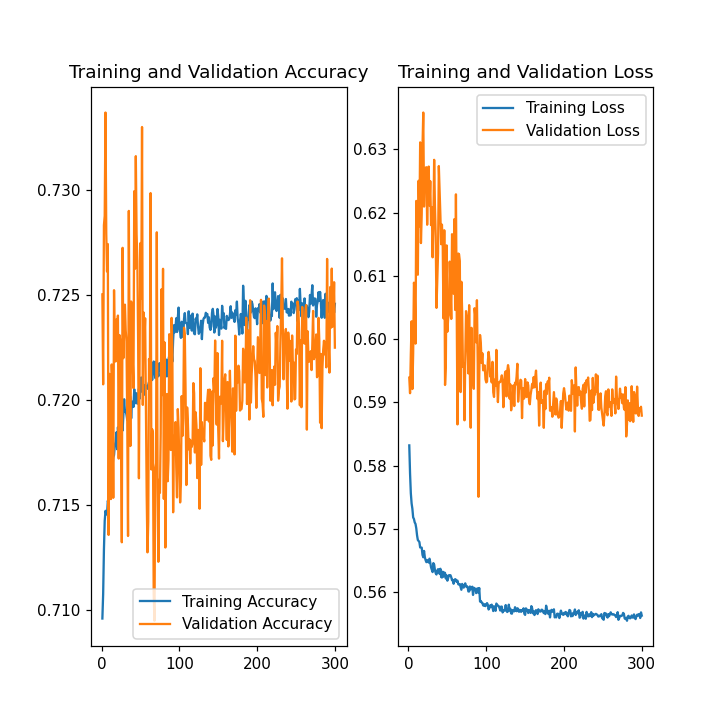

In [52]:
loss=history.history['loss']
val_loss=history.history['val_loss']

mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training Accuracy')
plt.plot(epochs_range, val_mae, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
model_1.load_weights("model_checkpoints/MLP_on_GlobTau_Dropout.h5")#MLP_on_GlobTau.h5

In [54]:
test_loss, test_acc = model_1.evaluate( test['features'][:], test['label'], verbose=2)

3125/3125 - 6s - loss: 0.5921 - accuracy: 0.7337


<IPython.core.display.Javascript object>


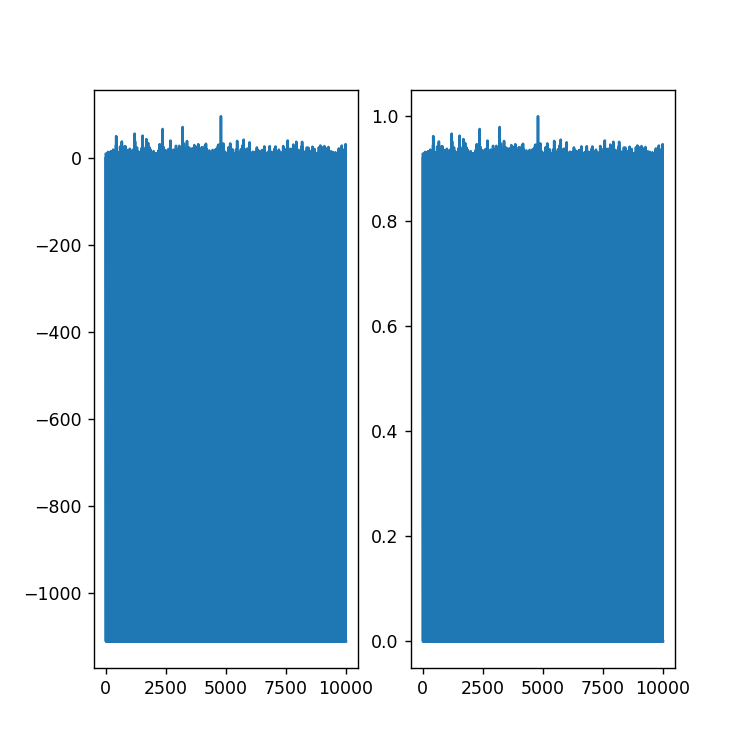

In [88]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(train['features'][:10000,3], label='variable')
plt.subplot(1,2,2)
plt.plot(train_scaled[:,3], label='min-max variable')

In [ ]:
#Pre-processing
shuffled_ind, train = shuffle(train)
scaler = MinMaxScaler()
scaler.fit(train['features'][:10000])
train_scaled = scaler.transform(train['features'][:10000])
#max_ = np.zeros( len(train['features'][0,:]) )
#min_ = np.zeros( len(train['features'][0,:]) )
#for i in range( len(train['features'][0,:]) ):
#    max_[i] = np.max(train['features'][:10000,i])
#    min_[i] = np.min(train['features'][:10000,i])

print(np.max(train['features'][:10000], axis=0))
print(np.min(train['features'][:10000],axis = 0))

### Plot of mean of glob var

In [16]:
#printing correlation between variables
intra_tau = array_tau.mean(axis=1)
intra_qcd = array_qcd.mean(axis=1)

<IPython.core.display.Javascript object>


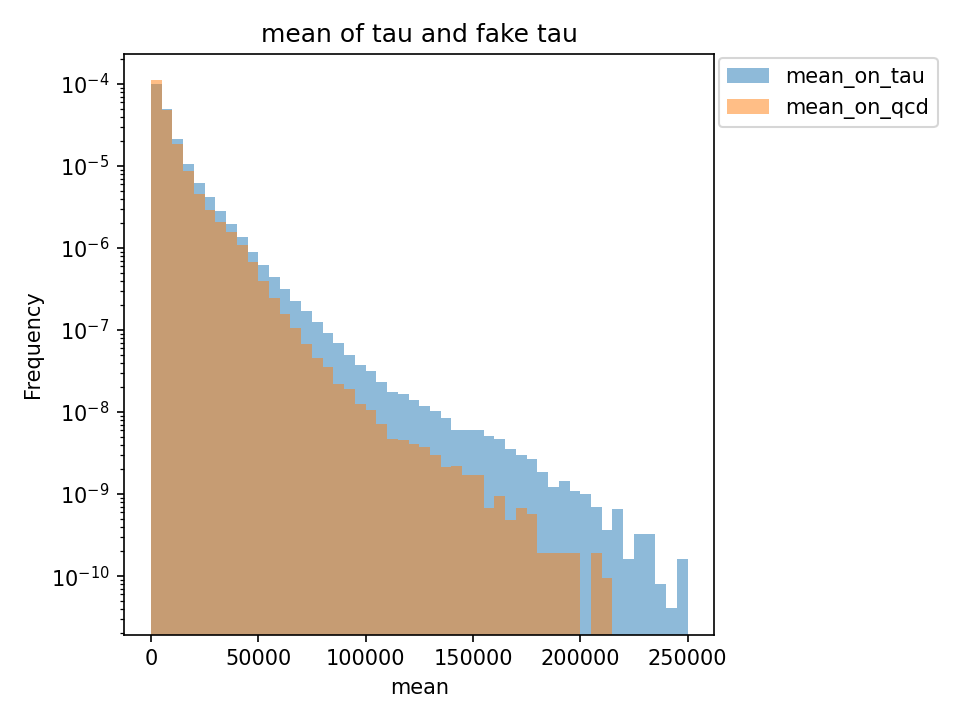

In [17]:
n_bins=50
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(intra_tau, bins=n_bins , label='mean_on_tau', lw=0.5, alpha=0.5, density=True, range=[0,250000])
ax1.hist(intra_qcd, bins=n_bins , label='mean_on_qcd', lw=0.5, alpha=0.5, density=True, range=[0,250000])
plt.title("mean of tau and fake tau")
plt.xlabel('mean')
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
ax.set_yscale('log')
ax1.set_yscale('log')

### Test also on track variables

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
array_tau = np.load('ntuples/dataset_tau.npy')
array_qcd = np.load('ntuples/dataset_fake_tau.npy')
array_tau_Glob = np.load('ntuples/datGlob_tau.npy')
array_qcd_Glob = np.load('ntuples/datGlob_fake_tau.npy')
print(array_tau.shape)
print(array_qcd.shape)
print(array_tau_Glob.shape)
print(array_qcd_Glob.shape)

(4916408, 10, 8)
(1060682, 10, 8)
(4916408, 9)
(1060682, 9)


In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


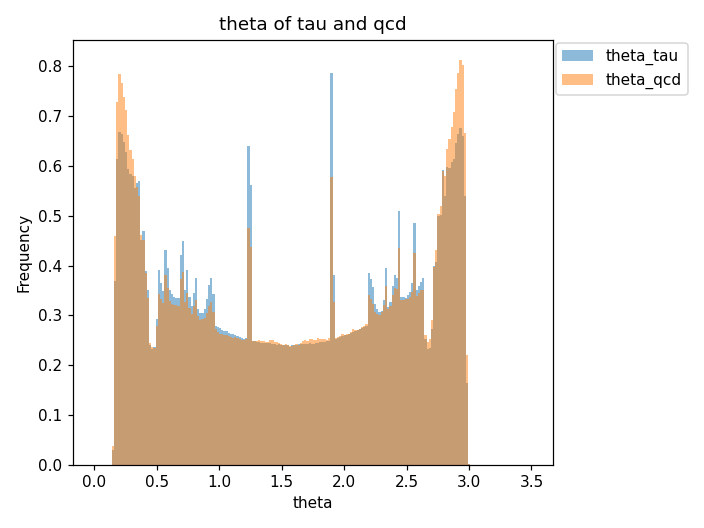

In [24]:
set_variable = ['DeltaEta', 'DeltaPhi', 'Pt', 'E', 'd0', 'z0', 'theta', 'Track-Flag']
mask = [-9, -9, -999, -999, -999, -999, -999, -9]
xlow = [-0.7, -0.7, 0, 0, -200, -260, 0, 0]
xup = [0.7, 0.7, 10**9, 10**9, 200, 260,3.5, 4]
setted_var = 6 #btw 0 and 3
#cleaning of variable from mask and values bigger than 10**9
a = array_tau[:,:,setted_var]#
b = array_qcd[:,:,setted_var]#test['features']
c =  (a != mask[setted_var])
d =  (b != mask[setted_var])
a = a[c]
b = b[d]

n_bins=200
fig=plt.figure(tight_layout=True)
ax = plt.subplot(1,1,1)
ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
ax.hist(a, bins=n_bins , label=set_variable[setted_var]+'_tau', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
ax1.hist(b, bins=n_bins , label=set_variable[setted_var]+'_qcd', lw=0.5, alpha=0.5, density=True, range=[xlow[setted_var], xup[setted_var]] )
plt.title(set_variable[setted_var]+" of tau and qcd")
plt.xlabel(set_variable[setted_var])
plt.ylabel('Frequency')
ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
#ax.set_yscale('log')
#ax1.set_yscale('log')